## Variational Autoencoder

The variational autoencoder (VA) is in the class of generative neural networks. Which in contrast to Generative Adverserial Network (GAN) approximates a lower bound on the log-likelihood of the data. 

Aditionally the VA leverages a encoding scheme that maps the an input, $\mathcal{X} \sim P(\mathcal{X} : \theta ^*)$, to some lower-dimensional vector space $\mathcal{z}$. That is we have a set of two non-linear maps $\phi$ and $\psi$ where they map to and from the latent space respectively. More formally the autoencoder can be stated as constisting of these two maps:

$ \psi: \mathcal{X} \rightarrow \mathcal{z}$ and $\phi: \mathcal{z} \rightarrow \mathcal{X}$

That then is subject to the optimization problem:

$\mathcal{O} = \text{argmin} _{\phi, \psi} ||\mathcal{X} - \psi  \circ \phi (\mathcal{X}) ||^2 $

The objective of the VA is to minimize the squared pixel-distance from the reconstructed input, or maximise some MLE for the data. Which is to say the MSE and Binary crossentropy are both valid cost functions. 

What differentiates a VA from an ordinary autoencoder is the restriction placed on the latent space. One imposes and additional cost forcing the latent variable to a normal, zero mean, unit variance distribution. In practice this is achieved with the addition of a Kullback-Leibler Divergence (KL-divergence) term to the loss function. This divergence is defined as :

$D_{KL}(P||Q) = \int^{\infty}_{-\infty} P(x) \log{\frac{P(x)}{Q(x)}}dx$

The KL-divergence measures the overlap between two distributions and is valued at unity for perfectly overlapping distributions. 

We introduce this constraint on the latent space to convert the algorithm to a generative one. After training one can then draw samples from a normal distribution and feed these to the decoder to create new samples.

Of-course this is not an integral (or sum in the discrete case) we want to compute, and it can be  quite easily shown (given some patience and some nicely featured gaussian integrals) that two normal distributions,$P, Q$ , with means $\mu_1$ and $\mu_2$, and corresponding standard deviations $\sigma_1$ and $\sigma_2$ that the KL-divergence takes the following form 

$D_{KL}(P||Q) = \log{\frac{\sigma_2}{\sigma_1}} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2 ^2} - \frac{1}{2}$ 

Which further simplifies when, as in the case for the VA, that $P \sim \mathcal{N}(0, 1)$, to 

$D_{KL}(P||Q) = \log{\sigma_2} + \frac{\mu_2^2}{2\sigma_2 ^2} - \frac{1}{2}$ 

Traditionally VAs have struggled with problems related to the lower bound approximation and also related to the context-less prediciton of each pixel value. There have been numerous models proposed in remedy to those issues but will not be covered just yet.

#### In this notebook the focus is on demostrating the usefulness of the latent space for clustering data 

To summarize  the VA has two parts, the encoder and the decoder as shown in the figures below. The last "lambda" layer in the encoder simply samples from the normal distributions according to the latent layer representation of $\sigma_2$ and $\mu_2$ as described above

<img src="https://raw.githubusercontent.com/copperwire/clustering_cnn_representations/master/images/encoder.png" width="400" /> 
<img src="https://raw.githubusercontent.com/copperwire/clustering_cnn_representations/master/images/decoder.png" width="400" /> 


In [313]:

# importing the mnist dataset
from keras.datasets import mnist

# preparing data and loading models
from keras.utils import to_categorical
from keras.models import load_model

#useful plotting
import matplotlib.pyplot as plt

#clustering tools 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import numpy as np


We begin by importing the data and models, previously trained (script is located in the repository). Training happened on a single i5-quad core processor and took on the order of 5 minutes to run. 
##### The dimensionality of the latent space was arbitrarily chosen to be $\text{Dim}(\mathcal{z}) = 10$

In [314]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1)/255
X_test = X_test.reshape(10000, 28, 28, 1)/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [315]:
encoder = load_model("./../models/mnist_enc.h5")
decoder = load_model("./../models/mnist_dec.h5")

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [316]:
tX_train = encoder.predict(X_train)
tX_test = encoder.predict(X_test)

## Clustering

We choose to to cluster with K-means in this demonstration simply for the readability of the centroid - we wil show that it carries useful information of the objects in each cluster

In [317]:
k_means = KMeans(
            n_clusters=10,
            random_state=42,
            n_jobs=4,
            precompute_distances=True
            )

k_means.fit(tX_train[2])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=4, precompute_distances=True,
    random_state=42, tol=0.0001, verbose=0)

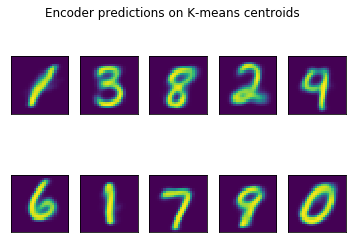

In [318]:
clusters = k_means.cluster_centers_
fig, axs = plt.subplots(2, 5)

fig.suptitle("Encoder predictions on K-means centroids")

for j in range(5):
    for i in range(2):
        c_i = decoder.predict(clusters[i+2*j].reshape(1, 10))
        axs[i, j].imshow(c_i.reshape((28, 28)))
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

As we can see from the figure above the custers for the figures three - five and eight seem to be very close in the latent space while four seem to have been replaced with a nine-like centroid. And the nine-centroid might be the slanted line. To further explore this let's look at an arbitrary four and nine from the test-set

In [319]:
def plot_digit_reconst(target):
    fig, ax = plt.subplots(1, 2)

    num = 0
    while target[num] != 1:
        num += 1
        
    fig.suptitle("Comparison of input value for the digit {} with the reconstruction".format(num))

    for i, y in enumerate(y_train):
        if all(y == target):
            ax[0].imshow(X_train[i].reshape((28, 28)))
            ax[0].set_title("Real digit")

            pred_val = decoder.predict(encoder.predict(X_train[i].reshape((1, 28, 28, 1)))[2])
            ax[1].imshow(pred_val.reshape((28, 28)))
            ax[1].set_title("Reconstructed digit")

            break
            
    return fig, ax, i


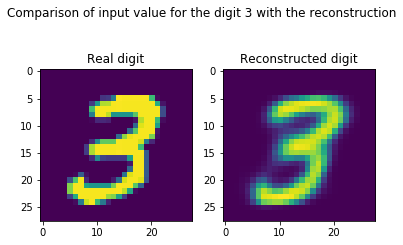

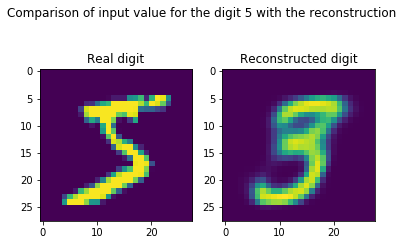

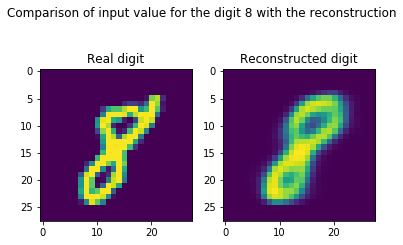

In [320]:
four = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

eight = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
three = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
five = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])



_, _, three_i = plot_digit_reconst(three)
_, _, five_i = plot_digit_reconst(five)
_, _, eight_i = plot_digit_reconst(eight)

We can clearly see the likeness in these reconstructions, reaffirming our impression from the centroids. Let's look at four and nine: 

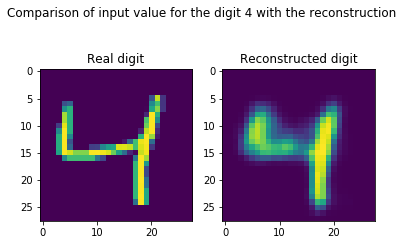

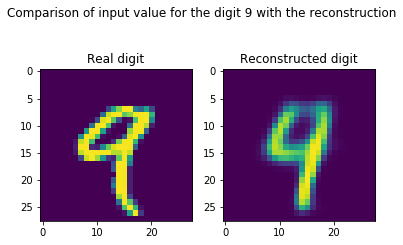

In [321]:
four = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
nine = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

_, _, four_i = plot_digit_reconst(four)
_, _, nine_i = plot_digit_reconst(nine)

We observe that these representations are quite similar indeed, but what cluster does that slanted line represent?

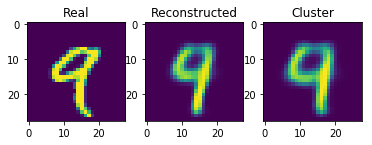

In [322]:
z_i = nine_i

zero = encoder.predict(X_train[z_i].reshape((1, 28, 28, 1)))[2]
pred = k_means.predict(zero.reshape((1, -1)))

sample_pred = decoder.predict(zero.reshape((1, -1)))
cluster_pred =  decoder.predict(clusters[pred].reshape((1, -1)))

fig, ax = plt.subplots(1, 3)

ax[0].imshow(X_train[z_i].reshape((28, 28)))
ax[1].imshow(sample_pred.reshape((28, 28)))
ax[2].imshow(cluster_pred.reshape((28, 28)))

titles = ["Real", "Reconstructed", "Cluster"]
_ = [a.set_title(titles[i]) for i, a in enumerate(ax)]

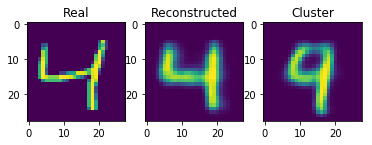

In [323]:
z_i = four_i

zero = encoder.predict(X_train[z_i].reshape((1, 28, 28, 1)))[2]
pred = k_means.predict(zero.reshape((1, -1)))

sample_pred = decoder.predict(zero.reshape((1, -1)))
cluster_pred =  decoder.predict(clusters[pred].reshape((1, -1)))

fig, ax = plt.subplots(1, 3)

ax[0].imshow(X_train[z_i].reshape((28, 28)))
ax[1].imshow(sample_pred.reshape((28, 28)))
ax[2].imshow(cluster_pred.reshape((28, 28)))

titles = ["Real", "Reconstructed", "Cluster"]
_ = [a.set_title(titles[i]) for i, a in enumerate(ax)]

Interestingly it seems like the slanted line cluster captures something other than a digit, and that four and nine have been grouped somewhat together in the latent space. To fully explore this let's plot up the clusters in latent space. 

In [324]:
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plotImage(ax, xData, yData, ims):
    for i in range(len(xData)):
        x = xData[i]
        y = yData[i]
        im = ims[i]
        
        bb = Bbox.from_bounds(x,y,1,1)  
        bb2 = TransformedBbox(bb,ax.transData)
        bbox_image = BboxImage(bb2,
                            norm = None,
                            origin=None,
                            clip_on=False)

        bbox_image.set_data(im)
        ax.add_artist(bbox_image)
    print("done!")
    return ax 

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [325]:
num_plots = 80
num_points = tX_test[2].shape[0]
picked = np.random.randint(low=0, high=num_points, size=(num_plots))
latent_p = tX_test[2][picked]

cluster_images = decoder.predict(clusters).reshape(10, 28, 28)
which_clusters = k_means.predict(latent_p)
picked_clusters = cluster_images[which_clusters]
pred_images = decoder.predict(latent_p).reshape((num_plots, 28, 28))
actual_p = X_test[picked].reshape((num_plots, 28, 28))


In [326]:
tsne = TSNE()
xy = tsne.fit_transform(tX_test[2])

In [327]:
x = xy[picked][:,0]
y = xy[picked][:,1]

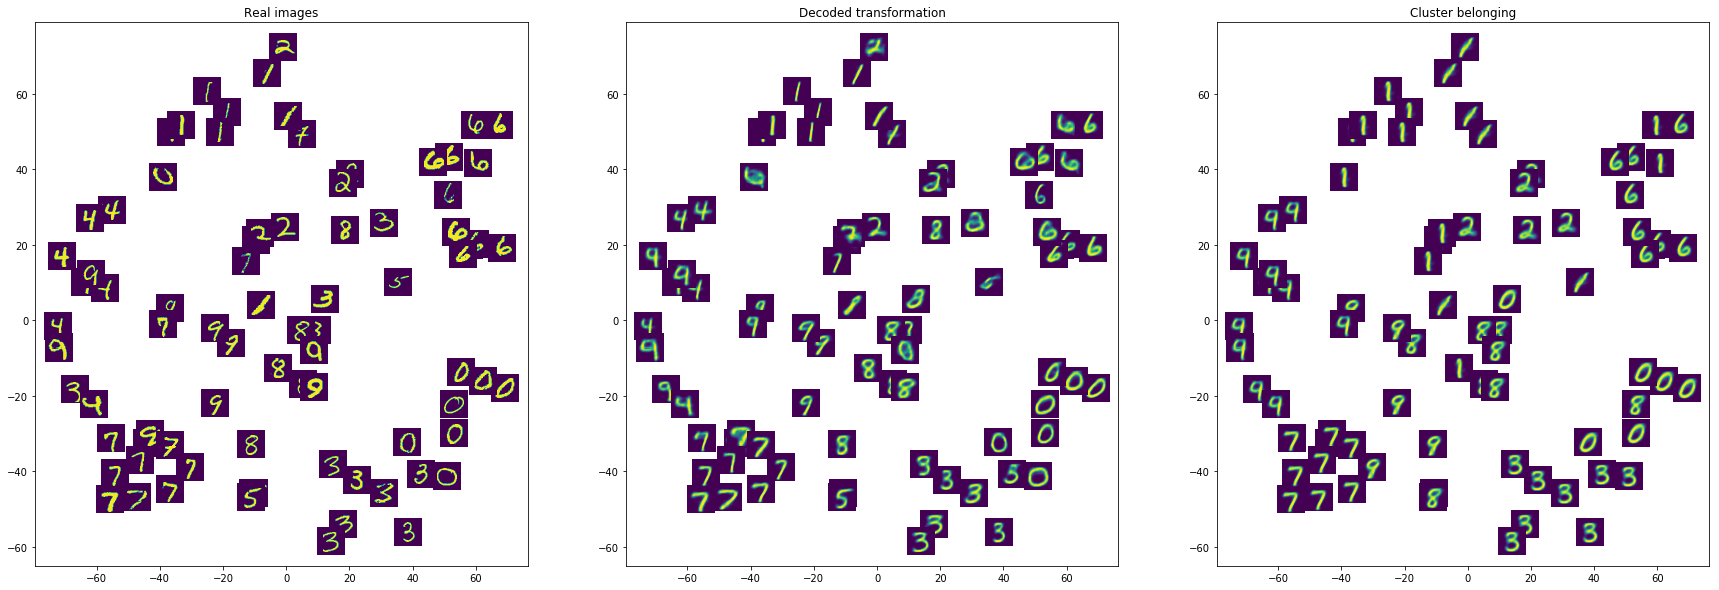

In [328]:
from skimage.transform import rescale

#pred_images = [rescale(i, 1/2.) for i in pred_images]
fig, ax = plt.subplots(1, 3, figsize = (30, 10))

for i in range(len(x)):
    artists = imscatter(x[i], y[i], actual_p[i], ax=ax[0])
    
for i in range(len(x)):
    artists = imscatter(x[i], y[i], pred_images[i], ax=ax[1])

for i in range(len(x)):
    artists = imscatter(x[i], y[i], picked_clusters[i], ax=ax[2])

    
titles = ["Real images",
          "Decoded transformation",
          "Cluster belonging"
         ]

a = [a.set_title(titles[i]) for i, a in enumerate(ax)]

The plots above are visualizations of the latent space using T-SNE as a nearest neighbour projection to a two-dimensional space. This comes with the caveat that the clusters we observe in the plot are likely not clustered in that way at all in the latent space; it is after all an already fairly compressed version of the data.

That aside we still observe that there are some strong clusters that present themselves. The leftmost picture are the T-SNE projected coordinates of the latent representation overlain with the real image that the encoder was fed. In the middle we see the reconstructed images as fed to the decoder. Lastly on the right is shown the points with the cluster they have been assigned to overlain on the point. 

Bear in mind that both the K-means and the VA have not been hyper-parameter tuned beyond a very rudimentary heuristic for the VA (does it work, yes/no). 

Those caveats and clarifications in mind we can see that there are some strongly preserved clusters: the digit 6 and 1 seem to be nicely delimited from other numbers, both in the upper right of the pictures. Other fairly strong clusters seem to emerge with 0, 7 and 4. The 9's seem to be clustered with 4's and 7's intermittently. While 8 and 2 seem distributed around the center of the image. 


The next step of this analysis will be to step away from the a-priori understanding that the number of centroids should be 10. As we can see from the top of the images the slanted line belonged to a group of "slanted ones". And as previously mentioned 4 and 9 and 3, 5, 8 look to be closely related in the latent space. As such it might give a more salient analyis to group together clusters especially pertaining to the clustering intended for the AT-TPC noise removal. 

Secondly there are two variations of VAs that have attempted to rectify some major challenges with the algorithm. These will be explored in replicas of this notebook, on forked git-branches for easy comparison.

## Generating

Up to now the investigation has centered on the clustering properties of the latent space. In the introduction it was claimed that the algorithm is a generative one. Let's see then how well it does at that.

To recap the latent space has $\text{Dim}(\mathcal{z}) = 10 $ and samples should be drawn from the normal univariate zero-centered distribution.

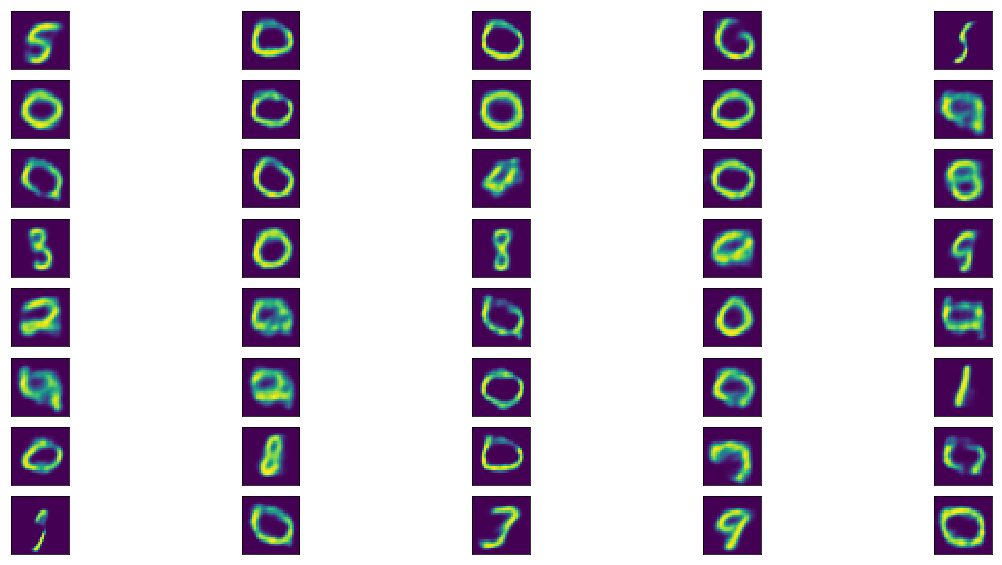

In [330]:
latent_dim = 10
n_x = 8
n_y = 5
n_samples = n_x*n_y

samples = np.random.normal(0, 1, size=(n_samples, latent_dim))
generated_images = decoder.predict(samples).reshape((n_samples, 28, 28))


fig, ax = plt.subplots(int(n_samples/n_y), int(n_samples/n_x), figsize=(20, 10))
ax_dim = ax.shape

generated_images = generated_images.reshape((ax_dim[0], ax_dim[1], 28, 28))

for i in range(ax_dim[0]):
    for j in range(ax_dim[1]):
        ax[i][j].imshow(generated_images[i][j])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])


We observe that the samples drawn from the distributions have a high chance of becoming 0's. This illustrates part of the challenge with VA's as the normal distribution usually captures one class much better than others. Though if the clusters are salient one can identify parts of the distribution that map to certain characters. 

Aditionally we see that there are classes entirely missing form the generation. If this i